## Optimize training parameter with 'self-prediction' 

"Self Prediction", when you train and test a model on the same (often low N) collection of images is a bad way to evaluate a model, but sometimes a very good way to trouble shoot a model.  "Self-prediction" with low N and a lot of training should result in an almost perfect prediction (as the model will memorize structure), if you are not getting almost perfect prediction in this case, the training and/or prediction settings may be sub-optimal.  In this example we use the self-prediction of a single image to trouble shoot whether the Cellpose settings are configured for optimal protrusion segmentation. 

Note:  After optimizing settings we still don't know if such a model can generalize, for this we need to train on many images and then test on 'un-seen' (by the trainer) images.  

num inputs:  1
num ground truth:  1
image label paths [WindowsPath('../../data/protrusions/labels/input0')]
ground_truth_label_paths ..\..\data\protrusions\labels\ground truth0


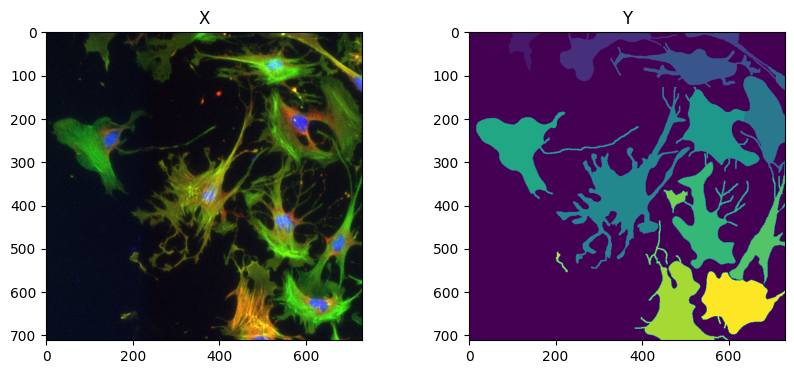

In [61]:
from skimage.io import imread
from tnia.deeplearning.dl_helper import quantile_normalization, get_label_paths
from tnia.plotting.plt_helper import imshow_multi2d
import json
import os
from skimage.measure import label
from cellpose import models, io

data_path = r'../../data'
parent_path = os.path.join(data_path, 'protrusions')
label_path = os.path.join(parent_path, 'labels')

# open the info file
json_name = os.path.join(label_path, 'info.json')
json_ = json.load(open(json_name))

# get number of inputs and number of ground truths for this problem
num_inputs = json_['num_inputs']
num_ground_truths = json_['num_truths']
print('num inputs: ', num_inputs)   
print('num ground truth: ', num_ground_truths)

image_label_paths, ground_truths_label_paths = get_label_paths(1, num_ground_truths, label_path)
print('image label paths',image_label_paths)
print("ground_truth_label_paths", ground_truths_label_paths[0])

X = imread(os.path.join(image_label_paths[0], 'img153_0.tif'))
Y = imread(os.path.join(ground_truths_label_paths[0], 'img153_0.tif'))

X = quantile_normalization(X, channels=True)
Y = label(Y)

fig = imshow_multi2d([X, Y], ['X', 'Y'], 1, 2)



2024-10-27 18:06:44,346 [INFO] >> cyto3 << model set to be used
2024-10-27 18:06:44,348 [INFO] ** TORCH CUDA version installed and working. **
2024-10-27 18:06:44,349 [INFO] >>>> using GPU
2024-10-27 18:06:44,452 [INFO] >>>> loading model C:\Users\bnort\.cellpose\models\cyto3
2024-10-27 18:06:44,587 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-10-27 18:06:44,593 [INFO] ** TORCH CUDA version installed and working. **
2024-10-27 18:06:44,594 [INFO] >>>> using GPU
2024-10-27 18:06:44,697 [INFO] >>>> loading model ../../data\protrusions\models\defaults
2024-10-27 18:06:44,815 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-10-27 18:06:44,816 [INFO] >>>> model diam_labels =  125.057 (mean diameter of training ROIs)
2024-10-27 18:06:44,819 [INFO] ** TORCH CUDA version installed and working. **
2024-10-27 18:06:44,820 [INFO] >>>> using GPU
2024-10-27 18:06:44,912 [INFO] >>>> loading model ../../data\protrusions

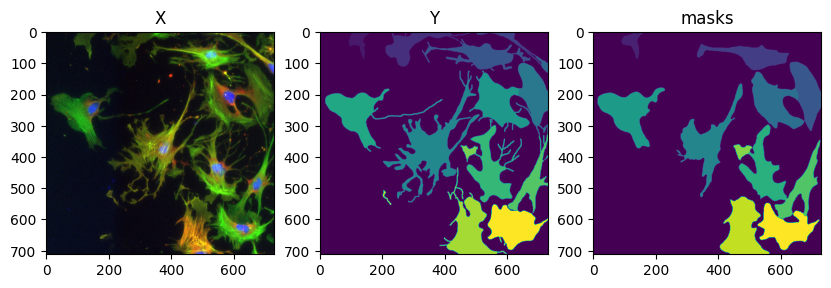

In [62]:
model_cyto3 = models.CellposeModel(gpu=True, model_type="cyto3")

new_models = False

if new_models:
    model_finetuned_defaults = models.CellposeModel(gpu=True, model_type="cyto3")
    model_finetuned_no_rescale = models.CellposeModel(gpu=True, model_type="cyto3")
    model_finetuned_no_rescale_bsize_512 = models.CellposeModel(gpu=True, model_type="cyto3")
else:
    model_finetuned_defaults = models.CellposeModel(gpu=True, pretrained_model=os.path.join(parent_path, 'models', 'defaults'))   
    model_finetuned_no_rescale = models.CellposeModel(gpu=True, pretrained_model=os.path.join(parent_path, 'models', 'no_rescale'))
    model_finetuned_no_rescale_bsize_512 = models.CellposeModel(gpu=True, pretrained_model=os.path.join(parent_path, 'models', 'no_rescale_bsize_512'))
logger = io.logger_setup()

masks = model_cyto3.eval(X, diameter=100, channels=[2,3])
fig = imshow_multi2d([X, Y, masks[0]], ['X', 'Y', 'masks'], 1, 3)


## Replicate training image to minimize 'randomness' in training

Here we copy the training data 100 times.  Cellpose training has a built in augmentation step (which I don't think we can turn off through the API.. correct me if I missed this option).  Thus if we only have 1 training image, each epoch will consist of 1 augmented image, and the model at the end of an epoch can be randomly different depending on the augmentation... however if we present 100 of the same images, an epoch will consist of 100 random augmentations, thus minimizing the randomness.  

In [5]:
X_list = [X]*100
Y_list = [Y]*100

print(len(X_list))

100


In [38]:
from cellpose import train

train.train_seg( model_finetuned_no_rescale.net, X_list, Y_list,   
                channels=[2,3], 
                save_path=parent_path, 
                n_epochs=500,
                min_train_masks=0,
                rescale = False,  
                model_name='no_rescale',
                normalize=False)

2024-10-26 06:37:55,489 [INFO] computing flows for labels


100%|██████████| 100/100 [00:28<00:00,  3.57it/s]

2024-10-26 06:38:23,640 [INFO] >>> computing diameters



100%|██████████| 100/100 [00:00<00:00, 421.16it/s]

2024-10-26 06:38:23,881 [INFO] >>> using channels [2, 3]


2024-10-26 06:38:24,448 [INFO] >>> n_epochs=200, n_train=100, n_test=None
2024-10-26 06:38:24,450 [INFO] >>> AdamW, learning_rate=0.00500, weight_decay=0.00001
2024-10-26 06:38:24,452 [INFO] >>> saving model to C:\Users\bnort\work\ImageJ2022\tnia\notebooks-and-napari-widgets-for-dl\data\protrusions\models\no_rescale
2024-10-26 06:38:26,875 [INFO] 0, train_loss=0.2434, test_loss=0.0000, LR=0.0000, time 2.42s
2024-10-26 06:38:38,890 [INFO] 5, train_loss=0.2466, test_loss=0.0000, LR=0.0028, time 14.44s
2024-10-26 06:38:50,857 [INFO] 10, train_loss=0.2546, test_loss=0.0000, LR=0.0050, time 26.41s
2024-10-26 06:39:14,255 [INFO] 20, train_loss=0.2458, test_loss=0.0000, LR=0.0050, time 49.80s
2024-10-26 06:39:37,033 [INFO] 30, train_loss=0.2401, test_loss=0.0000, LR=0.0050, time 72.58s
2024-10-26 06:39:59,496 [INFO] 40, train_loss=0.2438, test_loss=0.0000, LR=0.0050, time 95.04s
2024-10-26 06:40:22,067 [INFO] 50, train_loss=0.2290, test_loss=0.0000, LR=0.0050, time 117.62s
2024-10-26 06:40:44

WindowsPath('C:/Users/bnort/work/ImageJ2022/tnia/notebooks-and-napari-widgets-for-dl/data/protrusions/models/no_rescale')

In [20]:
train.train_seg( model_finetuned_no_rescale_bsize_512.net, X_list, Y_list,   
                channels=[2,3], 
                save_path=parent_path, 
                n_epochs=500,
                min_train_masks=0,
                rescale = False,  
                model_name='no_rescale_bsize_512',
                normalize=False,
                bsize=512)

2024-10-25 21:34:47,714 [INFO] computing flows for labels


100%|██████████| 100/100 [00:25<00:00,  3.88it/s]

2024-10-25 21:35:13,606 [INFO] >>> computing diameters



100%|██████████| 100/100 [00:00<00:00, 407.59it/s]

2024-10-25 21:35:13,855 [INFO] >>> using channels [2, 3]


2024-10-25 21:35:14,391 [INFO] >>> n_epochs=200, n_train=100, n_test=None
2024-10-25 21:35:14,393 [INFO] >>> AdamW, learning_rate=0.00500, weight_decay=0.00001
2024-10-25 21:35:14,397 [INFO] >>> saving model to C:\Users\bnort\work\ImageJ2022\tnia\notebooks-and-napari-widgets-for-dl\data\protrusions\models\no_rescale_bsize_512
2024-10-25 21:35:21,599 [INFO] 0, train_loss=0.1079, test_loss=0.0000, LR=0.0000, time 7.20s
2024-10-25 21:35:58,652 [INFO] 5, train_loss=0.1066, test_loss=0.0000, LR=0.0028, time 44.26s
2024-10-25 21:36:36,469 [INFO] 10, train_loss=0.1090, test_loss=0.0000, LR=0.0050, time 82.07s
2024-10-25 21:37:53,347 [INFO] 20, train_loss=0.1064, test_loss=0.0000, LR=0.0050, time 158.95s
2024-10-25 21:39:10,593 [INFO] 30, train_loss=0.1042, test_loss=0.0000, LR=0.0050, time 236.20s
2024-10-25 21:40:27,608 [INFO] 40, train_loss=0.1010, test_loss=0.0000, LR=0.0050, time 313.21s
2024-10-25 21:41:44,177 [INFO] 50, train_loss=0.0975, test_loss=0.0000, LR=0.0050, time 389.78s
2024-1

WindowsPath('C:/Users/bnort/work/ImageJ2022/tnia/notebooks-and-napari-widgets-for-dl/data/protrusions/models/no_rescale_bsize_512')

In [21]:
train.train_seg( model_finetuned_defaults.net, X_list, Y_list,   
                channels=[2,3], 
                save_path=parent_path, 
                n_epochs=500,
                min_train_masks=0,
                model_name='defaults',
                normalize=False)

2024-10-25 22:03:00,623 [INFO] computing flows for labels


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

2024-10-25 22:03:26,180 [INFO] >>> computing diameters



100%|██████████| 100/100 [00:00<00:00, 434.06it/s]

2024-10-25 22:03:26,417 [INFO] >>> using channels [2, 3]


2024-10-25 22:03:26,914 [INFO] >>> n_epochs=200, n_train=100, n_test=None
2024-10-25 22:03:26,915 [INFO] >>> AdamW, learning_rate=0.00500, weight_decay=0.00001
2024-10-25 22:03:26,918 [INFO] >>> saving model to C:\Users\bnort\work\ImageJ2022\tnia\notebooks-and-napari-widgets-for-dl\data\protrusions\models\defaults
2024-10-25 22:03:29,286 [INFO] 0, train_loss=0.0798, test_loss=0.0000, LR=0.0000, time 2.37s
2024-10-25 22:03:40,945 [INFO] 5, train_loss=0.0786, test_loss=0.0000, LR=0.0028, time 14.03s
2024-10-25 22:03:52,542 [INFO] 10, train_loss=0.0788, test_loss=0.0000, LR=0.0050, time 25.62s
2024-10-25 22:04:16,297 [INFO] 20, train_loss=0.0779, test_loss=0.0000, LR=0.0050, time 49.38s
2024-10-25 22:04:39,360 [INFO] 30, train_loss=0.0773, test_loss=0.0000, LR=0.0050, time 72.44s
2024-10-25 22:05:02,300 [INFO] 40, train_loss=0.0758, test_loss=0.0000, LR=0.0050, time 95.38s
2024-10-25 22:05:25,183 [INFO] 50, train_loss=0.0744, test_loss=0.0000, LR=0.0050, time 118.27s
2024-10-25 22:05:48,1

WindowsPath('C:/Users/bnort/work/ImageJ2022/tnia/notebooks-and-napari-widgets-for-dl/data/protrusions/models/defaults')

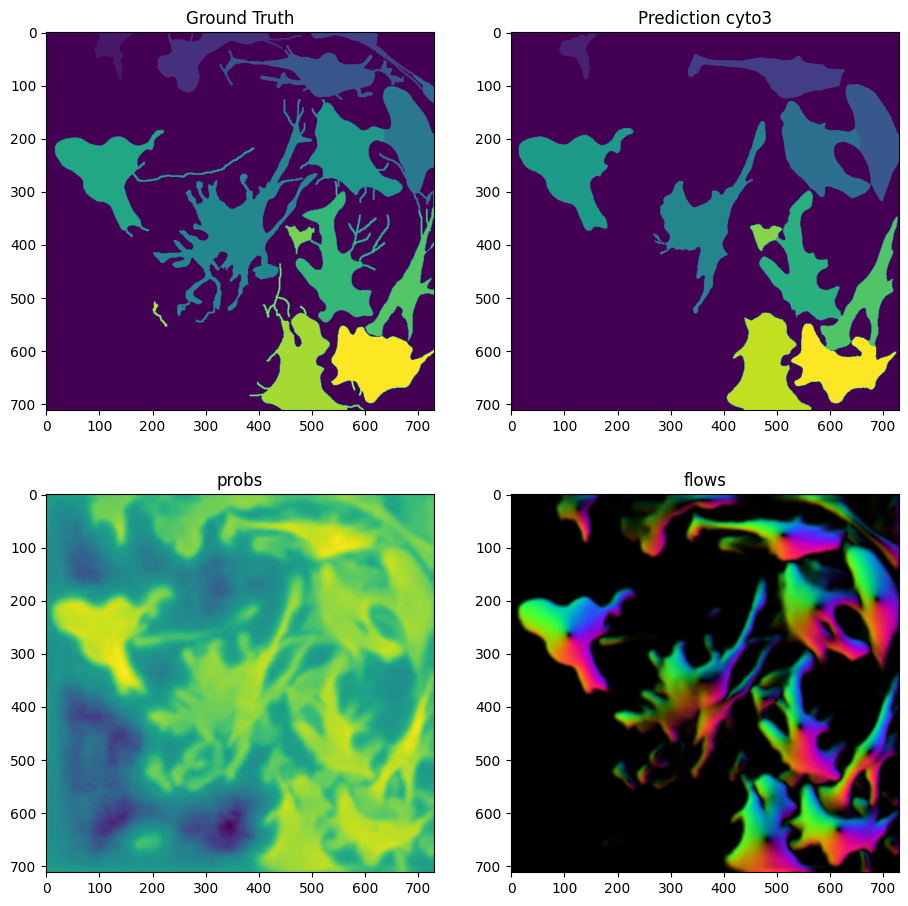

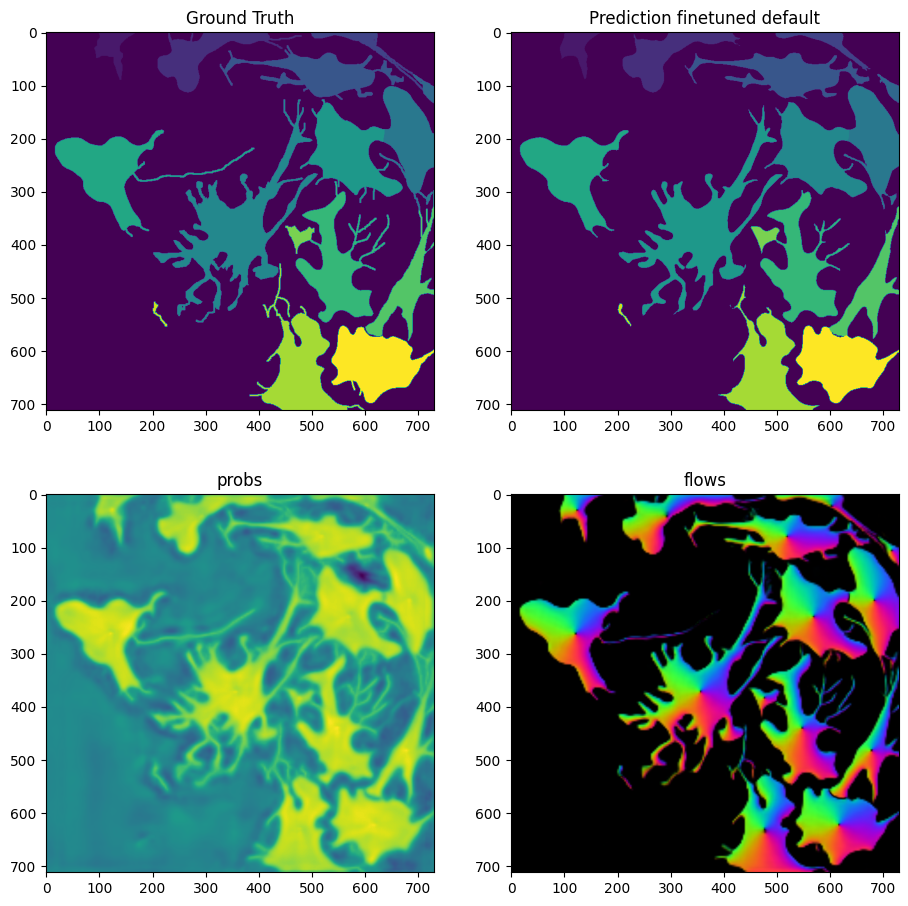

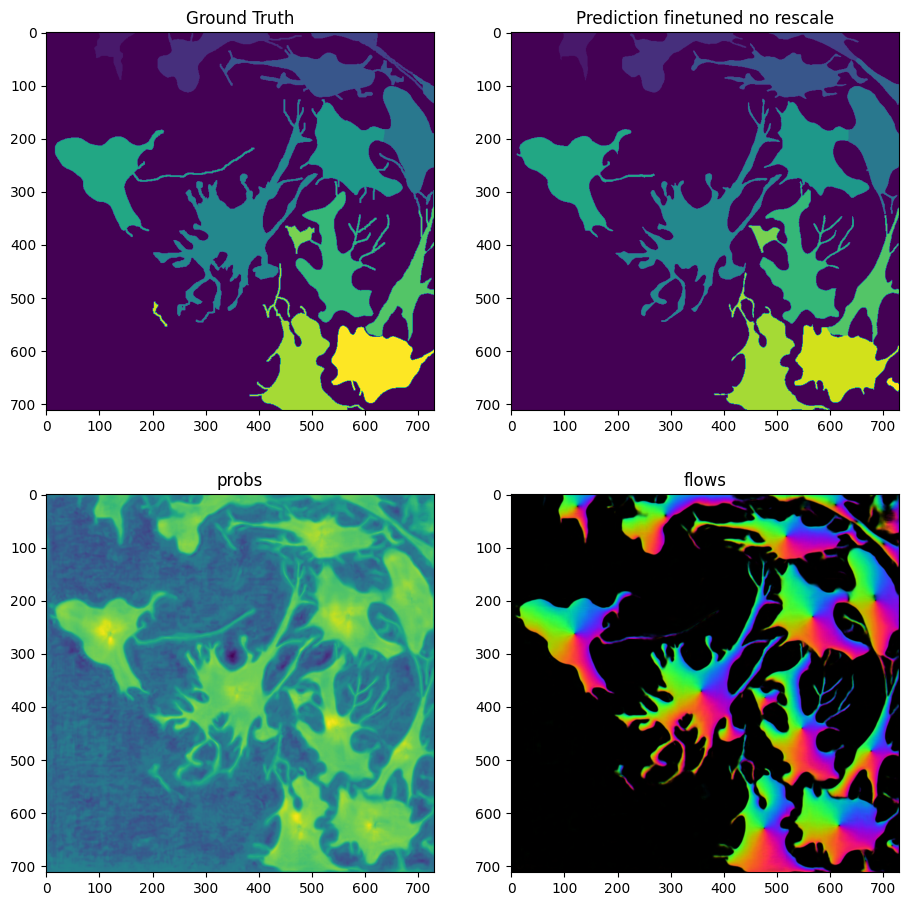

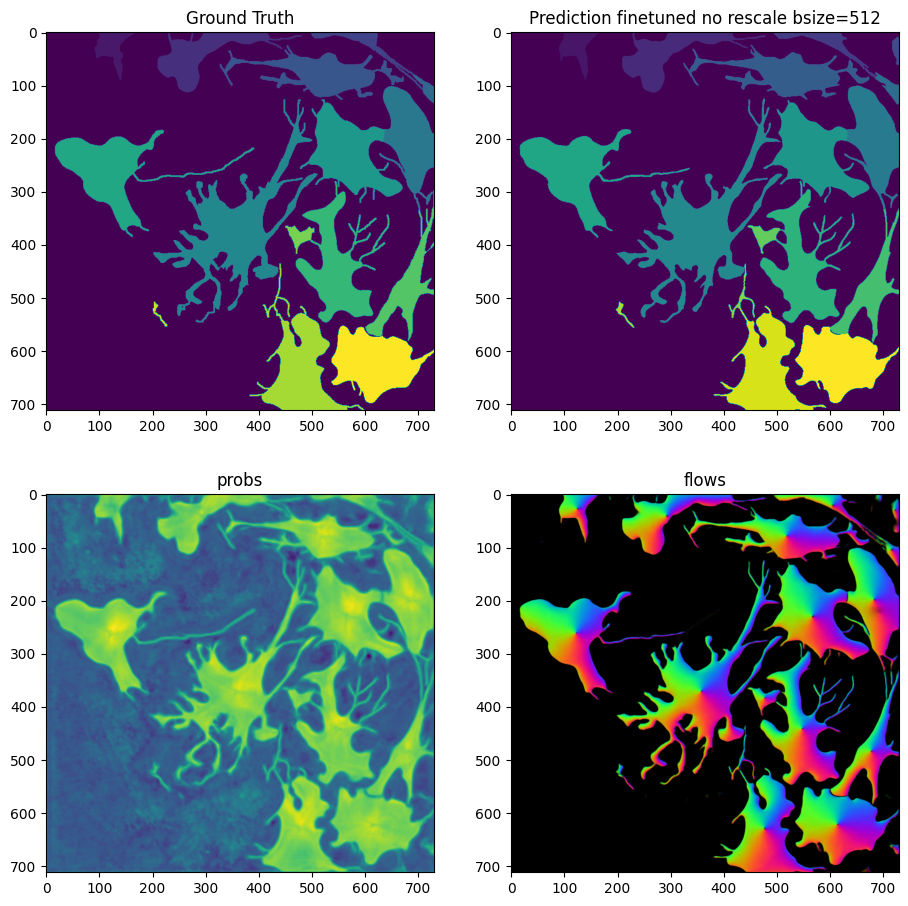

In [66]:

masks = model_cyto3.eval(X, diameter=100, niter=2000, channels=[2,3])
fog = imshow_multi2d([Y, masks[0], masks[1][2], masks[1][0]], ['Ground Truth', 'Prediction cyto3', 'probs', 'flows'], 2, 2, width=11, height=11)

masks_defaults = model_finetuned_defaults.eval(X, diameter=100, niter=2000, channels=[2,3], normalize=False)
fig = imshow_multi2d([Y, masks_defaults[0], masks_defaults[1][2], masks_defaults[1][0]], ['Ground Truth', 'Prediction finetuned default', 'probs', 'flows'], 2, 2, width=11, height=11)

masks_no_rescale = model_finetuned_no_rescale.eval(X, diameter=30, niter=2000, channels=[2,3], normalize=False)
fig = imshow_multi2d([Y, masks_no_rescale[0], masks_no_rescale[1][2], masks_no_rescale[1][0]], ['Ground Truth', 'Prediction finetuned no rescale', 'probs', 'flows'], 2, 2, width=11, height=11) 

masks_no_rescale_bsize_512 = model_finetuned_no_rescale_bsize_512.eval(X, diameter=30, niter=2000, bsize=512, channels=[2,3], cellprob_threshold=-1.0, normalize=False)
fig = imshow_multi2d([Y, masks_no_rescale_bsize_512[0], masks_no_rescale_bsize_512[1][2], masks_no_rescale_bsize_512[1][0]], ['Ground Truth', 'Prediction finetuned no rescale bsize=512', 'probs', 'flows'], 2, 2, width=11, height=11)


In [56]:
import napari

viewer = napari.Viewer()

viewer.add_image(masks_no_rescale_bsize_512[0], name='prediction')
viewer.add_image(masks_no_rescale_bsize_512[1][0], name='flow')
viewer.add_image(masks_no_rescale_bsize_512[1][2], name='prob')

<Image layer 'prob' at 0x11bfdeb8220>